<a href="https://colab.research.google.com/github/PenidoRafael/Valor-de-Aluguel-em-Sao-Paulo/blob/main/Aluguel_em_S%C3%A3o_Paulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Um Estudo Sobre o Preço de Aluguel em São Paulo

**Autor**: Rafael Penido Soares

Este é um estudo a respeito dos preços de aluguel em São Paulo. Nosso objetivo aqui é, ao final desta análise, conseguir prever o valor de um aluguel dadas algumas características. Claro, ao longo do estudo, espero também que nós consigamos flagrar várias relações interessantes e inesperadas entre os preços e tudo aquilo que pode defini-lo.

Antes de começarmos, dois aviso são importante: primeiro, este estudo é um projeto puramente pessoal, isto é, não tem caráter profissional ou acadêmico e, por isso, não tenho a intenção de desenvolver previsões completamente assertivas, mas sim apenas desenvolver minhas técnicas, treinar e prosseguir com meu aprendizado na área de Machine Learning(o que não quer dizer que este notebook não valoriza precisão nas previsões). Em segundo lugar, como o objetivo aqui é justamente desenvolver a qualidade dos meus estudos, qualquer crítica e sujestão são muito bem vindas e podem ser enviadas a mim através de qualquer canal, como o próprio github.   

#Setup

Primeiro, vamos preparar o ambiente e obter os dados.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import pandas as pd

#To get the data
housing = pd.read_csv("/content/sao-paulo-properties.csv")

#Analisando a Estrutura de Dados

In [ ]:
housing.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


Esta é uma análise apenas dos preços de aluguel, portanto vamos continuar a análise apenas com estes dados.

In [ ]:
housing = housing[housing['Negotiation Type'] == 'rent']

Vamos divir 'District' em Distrito e Cidade, para enquadrar o problema de forma mais clara.

In [ ]:
housing[['District','City']] = housing['District'].str.split('/', expand = True)
housing['City'].unique(), housing['Property Type'].unique()

(array(['São Paulo'], dtype=object), array(['apartment'], dtype=object))

Há apenas dados da cidade de São Paulo e apenas apartamentos, portanto, como estes atributos não variam, vamos retirar as colunas correspondentes.
Além disso, como selecionamos anteriormente, possuimos apenas dados sobre aluguel. Dessa forma, devemos retirar também a coluna 'Negotiation Type'.

In [ ]:
housing = housing.drop(columns = ['City', 'Property Type', 'Negotiation Type'], axis = 1)

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7228 entries, 0 to 11209
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          7228 non-null   int64  
 1   Condo          7228 non-null   int64  
 2   Size           7228 non-null   int64  
 3   Rooms          7228 non-null   int64  
 4   Toilets        7228 non-null   int64  
 5   Suites         7228 non-null   int64  
 6   Parking        7228 non-null   int64  
 7   Elevator       7228 non-null   int64  
 8   Furnished      7228 non-null   int64  
 9   Swimming Pool  7228 non-null   int64  
 10  New            7228 non-null   int64  
 11  District       7228 non-null   object 
 12  Latitude       7228 non-null   float64
 13  Longitude      7228 non-null   float64
dtypes: float64(2), int64(11), object(1)
memory usage: 847.0+ KB


Há apenas 7228 instâncias no conjunto de dados, o que é muito pouco para os padrões de Aprendizado de Máquina, contudo, para uma breve análise, deve ser suficiente.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa84f53650>,
      dtype=object)

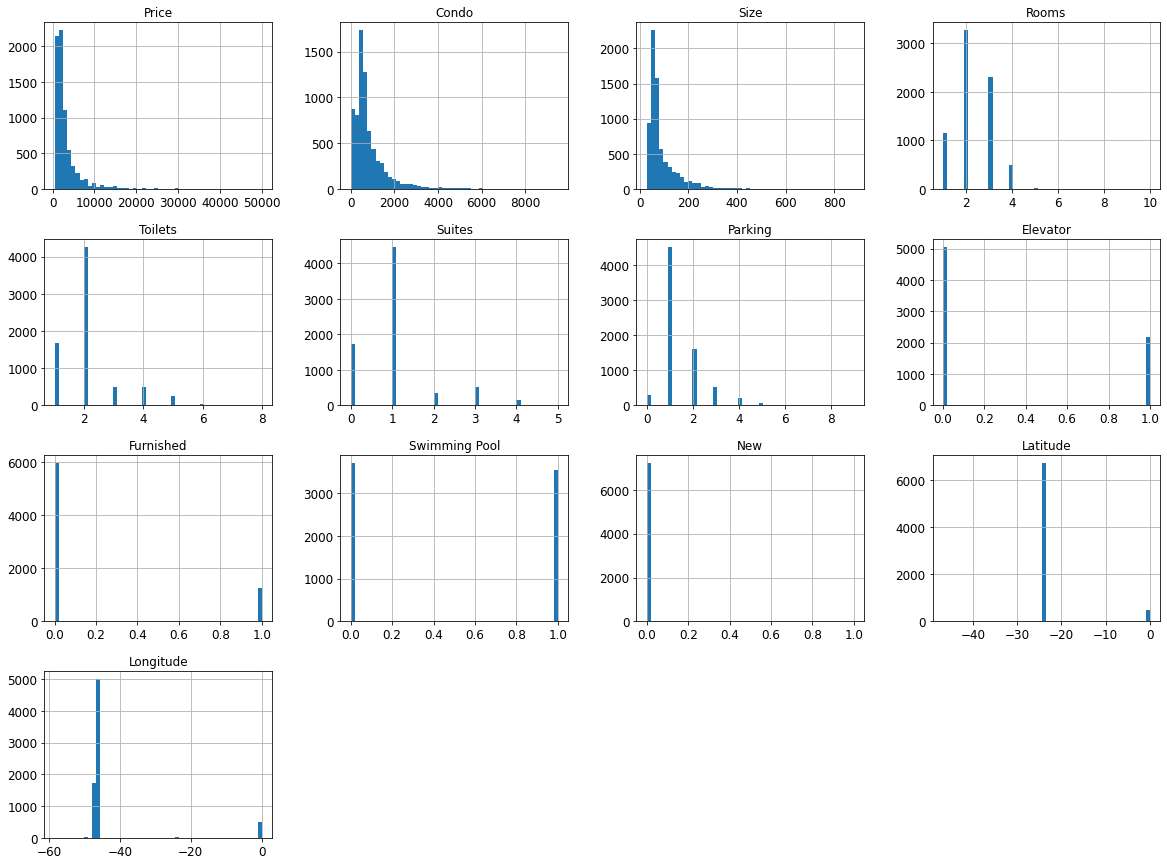

In [ ]:
housing.hist(bins=50, figsize=(20,15))

"New" também não varia, deve ser removido!.

In [ ]:
housing = housing.drop(columns = 'New', axis = 1)

In [ ]:
housing[['Latitude', 'Longitude']].value_counts()

Latitude    Longitude 
 0.000000    0.000000     483
-23.505391  -46.622783     37
-23.604294  -46.518325     35
-23.522756  -46.655492     21
-23.545395  -46.616793     17
                         ... 
-23.578520  -46.638730      1
-23.578490  -46.635167      1
            -46.673904      1
-23.578435  -46.672570      1
-23.561178  -46.583734      1
Length: 4878, dtype: int64

Péssimo! muitos outliers em Longitude e Latitude

Vamos seguir a seguinte estratégia para cuidar dos dados perdidos:
os valores de Latitude e Longitude iguais a zero claramente são errôneos, já que os dados são de São Paulo, portanto vamos substituí-los(Latitude e Longitude) pela média dos valores do Distrito ao qual o dado em questão pertence.

In [ ]:
#Para fazer isso, primeiro vamos remover os valores 0 para que eles não atrapalhem o cálculo da média.
(housing.loc[(housing['Latitude'] == 0) & (housing['Longitude'] == 0), ['Latitude', 'Longitude']]) = (housing.loc[(housing['Latitude'] == 0) & (housing['Longitude'] == 0), ['Latitude', 'Longitude']]).replace(0, np.NaN)

In [ ]:
#Em seguida, vou mapear as médias de Latitude e Longitude dos Distritos e realizar a substituição através das funções da Pandas .groupby, .agg, .assign, .map, .apply
means_mapping = (
    housing
    .groupby("District")
    .agg(LongitudeMean=("Longitude", "mean"), LatitudeMean=("Latitude", "mean"))
    .reset_index()
).set_index("District").transpose().to_dict("list")

housing = housing.assign(
    Longitude=housing["Longitude"].fillna(housing["District"].map(means_mapping).apply(lambda x: x[0])),
    Latitude=housing["Latitude"].fillna(housing["District"].map(means_mapping).apply(lambda x: x[1]))
)

In [ ]:
housing[['Latitude', 'Longitude']].value_counts()

Latitude    Longitude 
-23.505391  -46.622783    37
-23.604294  -46.518325    35
-23.611456  -46.539133    23
-23.522756  -46.655492    21
-23.550787  -46.686626    19
                          ..
-23.578202  -46.616857     1
-23.578178  -46.672085     1
-23.578152  -46.674580     1
-23.578139  -46.641808     1
-21.857741  -51.976357     1
Length: 4949, dtype: int64

#Hora de Criar um conjunto de Testes

Pode parecer estranho decidir abrir mão de parte dos dados agora, sem antes ter feito uma análise mais profunda para decidir quais algoritmos usar. Contudo, como Aurelion Géron cita em seu brilhante livro "Hands-On Machine Learning with Scikit-Learn and Tensorflow", o cérebro humano é uma incrível máquina de detecção de padrões, o que pode levar a um sobreajuste. Dessa forma, nós podemos identificar algum suposto padrão, o que nos levará a selecionar umm tipo específico de modelo.(Data Snooping Bias)

Além disso, para fins de estudo vou criar dois conjuntos de testes: um terá amostragem aleatória e outro terá viés de amostragem estratificada. Dessa forma, será possível conferir se a amostragem aleátoria apresenta um viés significativo de amostragem.

**Amostragem Aleatória**

In [ ]:
from sklearn.model_selection import train_test_split

rand_train_set, rand_test_set = train_test_split(housing, test_size=0.2, random_state=42)

**Amostragem Estratificada**

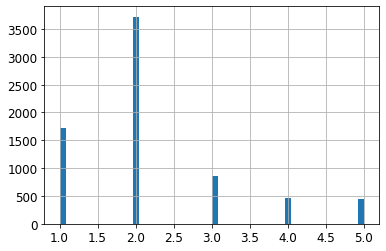

In [ ]:
housing['Size_cat'] = np.ceil(housing['Size'] / 50)
housing['Size_cat'].where(housing['Size_cat'] < 5, 5.0, inplace=True)

housing['Size_cat'].hist(bins=50)

In [ ]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["Size_cat"])

In [ ]:
strat_test_set["Size_cat"].value_counts() / len(strat_test_set)

2.0    0.514523
1.0    0.239281
3.0    0.118949
4.0    0.065007
5.0    0.062241
Name: Size_cat, dtype: float64

In [ ]:
housing["Size_cat"].value_counts() / len(housing)

2.0    0.514804
1.0    0.238932
3.0    0.118982
4.0    0.065302
5.0    0.061981
Name: Size_cat, dtype: float64

As proporções no conjunto de teste estratificado está quase identica às proporções do conjunto geral de dados, perfeito!

In [ ]:
#Removendo o atributo Size_cat

for set_ in (strat_train_set, strat_test_set):
    set_.drop("Size_cat", axis=1, inplace=True)

In [ ]:
#Vamos deixar o conjunto de teste de lado e prosseguir apenas com o conjunto de treinamento. Exploraremos o conjunto estratificado, mas, no fim da análise, ainda faremos comparações com o conjunto aleatório.

housing = strat_train_set.copy()

#Explorando os dados

**Analisando os Distritos**

In [ ]:
housing['District'].value_counts()

Mooca              142
Morumbi            131
Vila Leopoldina    130
Cambuci            127
Vila Mariana       127
                  ... 
Lajeado              7
Parque do Carmo      5
Guaianazes           5
Jardim São Luis      2
Grajaú               2
Name: District, Length: 94, dtype: int64

Qual Distrito deve ter o maior preço médio?

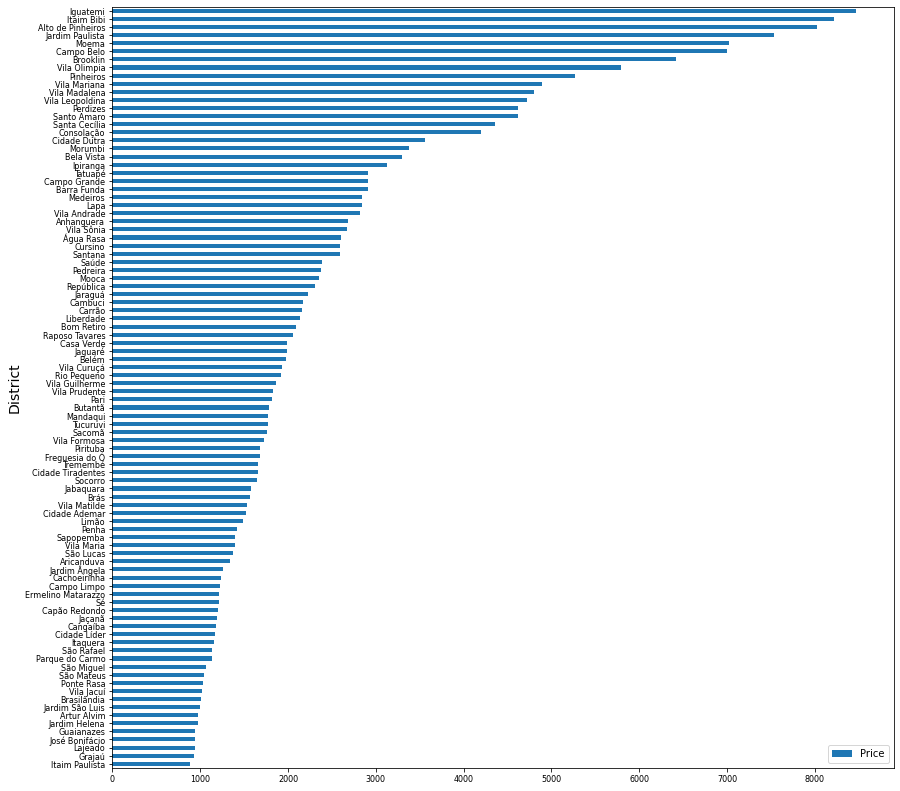

In [ ]:
grouped = housing.groupby('District')['Price'].mean().reset_index()
grouped = grouped.sort_values(by = 'Price',ascending = True)


grouped.plot.barh(x='District', y='Price', figsize=(14, 14), fontsize=8)

**Analisando Relações**

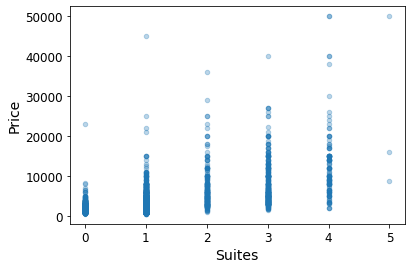

In [ ]:
housing.plot(kind='scatter', x='Suites', y='Price', alpha=0.3)

Claro, a tendência é o valor do aluguel subir com o aumento da quantidade de suítes.

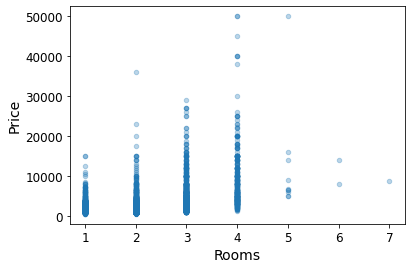

In [ ]:
housing.plot(kind='scatter', x='Rooms', y='Price', alpha=0.3)

A mesma coisa parece acontecer com quartos até 4, depois disso a quantidade de dados cai muito. O que será que acontece com a quantidade de toalete?

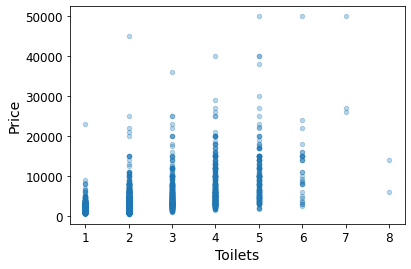

In [ ]:
housing.plot(kind='scatter', x='Toilets', y='Price', alpha=0.3)

O padrão parece continuar, vamos continuar analisando o número de vagas.

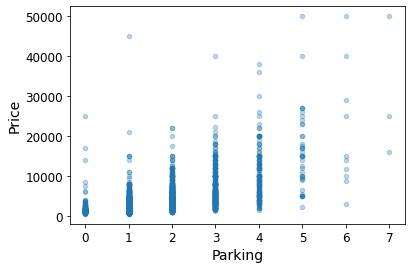

In [ ]:
housing.plot(kind='scatter', x='Parking', y='Price', alpha=0.3)

Okay, conseguimos flagrar alguns padrões aqui! Contudo, alguns outliers também foram notados, o que pode atrapalhar nosso modelo.

**Vizualiando Dados Geográficos**

(-23.9, -23.35)

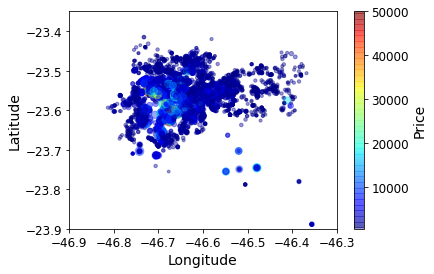

In [ ]:
ax = housing.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4, s=housing['Size']/5 , c = 'Price' ,cmap=plt.get_cmap('jet'),colorbar=True,
    sharex=False)
ax.set_xlim(-46.9, -46.3)
ax.set_ylim(-23.9, -23.35)

In [ ]:
#Buscando Correlações

corr_matrix = housing.corr()
corr_matrix['Price'].sort_values(ascending=False)

Price            1.000000
Size             0.731385
Condo            0.699513
Parking          0.634826
Suites           0.585442
Toilets          0.579031
Rooms            0.399655
Swimming Pool    0.211252
Furnished        0.159790
Elevator         0.030300
Latitude        -0.005602
Longitude       -0.024790
Name: Price, dtype: float64

Muito interessante! O tamanho da residência e o valor do condominio parecem ser muito determinantes no preço do aluguel.

Vamos plotar os atributos mais promissores para prever o valor do aluguel.

(0.0, 20000.0)

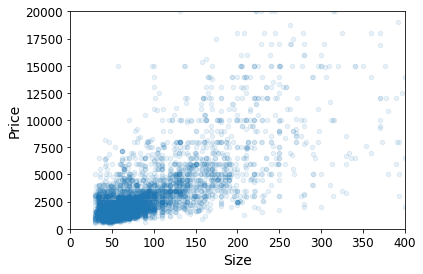

In [ ]:
ax = housing.plot(kind='scatter', x='Size', y='Price', alpha=0.1)
ax.set_xlim(0, 400)
ax.set_ylim(0, 20000)

A tendência ascendente é bem clara, contudo, além disso, é possivél notar algumas linhas verticais e horizontais, o que pode ser um problema, já que o algoritmo selecionado pode tentar reproduzir essa disposição.

(0.0, 20000.0)

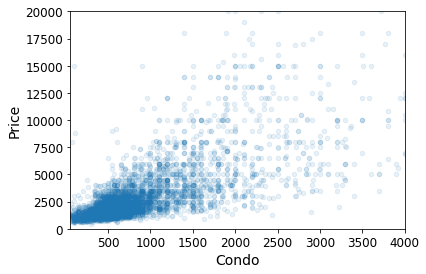

In [ ]:
ax = housing.plot(kind='scatter', x='Condo', y='Price', alpha=0.1)
ax.set_xlim(50, 4000)
ax.set_ylim(0, 20000)

Novamente uma clara tendência ascendente muito forte.

Vamos tentar combinar alguns atributos para conseguir relações mais fortes.

In [ ]:
housing["Condo_per_size"] = housing["Condo"]/housing["Size"]
housing["Rooms_per_size"] = housing["Rooms"]/housing["Size"]
housing["Toilets_per_size"] = housing["Toilets"]/housing["Size"]
housing["Toilets_per_room"] = housing["Toilets"]/housing["Rooms"]

In [ ]:
#Vamos analisar as novas correlações
corr_matrix = housing.corr()
corr_matrix['Price'].sort_values(ascending=False)

Price               1.000000
Size                0.731385
Condo               0.699513
Parking             0.634826
Suites              0.585442
Toilets             0.579031
Rooms               0.399655
Condo_per_size      0.214777
Swimming Pool       0.211252
Toilets_per_room    0.193582
Furnished           0.159790
Elevator            0.030300
Latitude           -0.005602
Longitude          -0.024790
Toilets_per_size   -0.273775
Rooms_per_size     -0.515447
Name: Price, dtype: float64

Supreendente! Pensei que os atributos "Rooms_per_size" e "Toilets_per_size" representassem correlações positivas, mas aparentemente, quanto mais banheiros e quartos um espaço tiver, menor vai ser o preço de seu aluguel.

#Preparando os Dados para algoritmos de aprendizado de Máquina

Vamos reverter para um conjunto de treinamento limpo e separar os previsores dos rótulos, já que não queremos necessariamente aplicar as mesmas transformações nos previsores e nos valores alvo.

In [ ]:
housing = strat_train_set.drop('Price', axis=1)
housing_labels = strat_train_set['Price'].copy()

In [ ]:
housing

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,District,Latitude,Longitude
2521,470,65,2,1,0,0,0,0,0,República,-23.541412,-46.646156
1355,800,110,3,3,2,2,1,0,1,Santo Amaro,-23.629488,-46.694142
3409,620,49,1,2,1,1,0,0,0,Campo Belo,-23.620655,-46.677333
2600,850,83,3,3,2,2,0,0,1,Casa Verde,-23.550787,-46.686626
9896,2875,70,2,2,1,2,1,0,1,Itaim Bibi,-23.581399,-46.676908
...,...,...,...,...,...,...,...,...,...,...,...,...
3838,2700,194,4,3,2,5,0,0,1,Moema,-23.602063,-46.658992
841,450,55,1,2,1,1,1,0,1,Campo Grande,-23.671438,-46.686446
868,0,42,2,2,1,1,1,0,1,Campo Limpo,-23.617328,-46.759936
4034,687,84,3,2,1,2,0,0,1,Saúde,-23.611371,-46.631732


Vamos criar transformadores personalizados e um pipeline para automatizar a preparação de dados.

As próximas etapas apenas preparam os dados de forma automática, o que vai nos poupar tempo futuramente(lembre-se que estamos trabalhando apenas com o conjunto de treinamento agora).

In [ ]:
#Criando um transformador personalizado.

from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X):
    condo_per_size = X[:, 0] / X[:, 1]
    rooms_per_size = X[:, 2] / X[:, 1]
    toilets_per_size = X[:, 3] / X[:, 1]
    toilets_per_room = X[:, 3] / X[:, 2]

    return np.c_[X, condo_per_size, rooms_per_size, toilets_per_size, toilets_per_room]


attr_adder = FunctionTransformer(add_extra_features, validate=False)
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [ ]:
housing_extra_attribs

array([[470, 65, 2, ..., 0.03076923076923077, 0.015384615384615385, 0.5],
       [800, 110, 3, ..., 0.02727272727272727, 0.02727272727272727, 1.0],
       [620, 49, 1, ..., 0.02040816326530612, 0.04081632653061224, 2.0],
       ...,
       [0, 42, 2, ..., 0.047619047619047616, 0.047619047619047616, 1.0],
       [687, 84, 3, ..., 0.03571428571428571, 0.023809523809523808,
        0.6666666666666666],
       [3500, 280, 3, ..., 0.010714285714285714, 0.014285714285714285,
        1.3333333333333333]], dtype=object)

**Manipulando atributos categóricos**

A maioria dos algoritmos de Aprendizado de Máquina tem preferência por trabalhar com atributos numéricos.

O único atributo categórico que restou foi o Distrito, o qual é referenciado indiretamente pela Latitude e Longitude. Dessa maneira, acredito que descartar o atributo Distrito não afetaria o desempenho do algoritmo de aprendizado de máquina selecionado.

Para impedir que o modelo faça relações com os números transformados das categorias, utiliza-se a estratégia de não utilizar base decimal, mas sim a binária(one-hot encoding)

Poderíamos codificar os Distritos e transformá-los em números, contudo, ao utilizar one-hot enconding, um atributo categórico com muitas categorias, como os Distritos, resultará em um grande número de características de entrada, o que pode diminuir o treinamento e degradar o desempenho. Uma solução seria produzir representações mais densas(embeddings), o que é mais complicado. Portanto, para deixar a análise mais simples, vamos prosseguir apenas descartando "District".

In [ ]:
#Criando um transformador personalizado.

def remove_district_feature(X):
    X = np.delete(X, 9, axis=1)

    return X


attr_district_remover = FunctionTransformer(remove_district_feature, validate=False)
housing_minus_district = attr_district_remover.fit_transform(housing.values)

In [ ]:
housing_minus_district

array([[470, 65, 2, ..., 0, -23.541412, -46.6461561],
       [800, 110, 3, ..., 1, -23.629488, -46.694142],
       [620, 49, 1, ..., 0, -23.6206548, -46.677333],
       ...,
       [0, 42, 2, ..., 1, -23.617328, -46.759936],
       [687, 84, 3, ..., 1, -23.6113708, -46.6317321],
       [3500, 280, 3, ..., 1, -23.5520102, -46.7101279]], dtype=object)

**Criando um pipeline.**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('district_remover', FunctionTransformer(remove_district_feature, validate=False)),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_prepared = num_pipeline.fit_transform(housing.values)

**Escalonamento das Características.**

No pipeline acima, aproveitei para aplicar uma das transformações mais importantes que precisamos aplicar, o Escalonamento das Características.

Os algoritmos de Aprendizado de Máquina, em geral, não funcionam bem quando os atributos numéricos têm escalas muito diferentes. Por exemplo, o preço do aluguel atinge valores superiores a 20.000, enquanto a quantidade de banheiros dificilmente passa de 5. Essa diferença entre as escalas pode fazer com que uma característica domine outra, fazendo com que o modelo negligencie a outra.

Essa transformação é aplicada pelo transformador fornecido do Scikit-Lean chamado StandardScaler().

Vale acrescentar que existem varias estratégias para realizar esse escalonamento.

In [ ]:
housing_prepared

array([[-0.42377661, -0.38520213, -0.36723807, ...,  0.08221844,
        -1.09327585, -1.10875613],
       [-0.03147314,  0.32080188,  0.83990833, ..., -0.27027189,
        -0.00522206,  0.04861807],
       [-0.24545685, -0.63622578, -1.57438446, ..., -0.96230392,
         1.23434942,  2.36336646],
       ...,
       [-0.98251186, -0.74604862, -0.36723807, ...,  1.7808861 ,
         1.85696524,  0.04861807],
       [-0.16580736, -0.08711154,  0.83990833, ...,  0.58074047,
        -0.32219011, -0.72296473],
       [ 3.17828253,  2.98792815,  0.83990833, ..., -1.93956536,
        -1.19385226,  0.82020087]])

In [ ]:
housing_prepared.shape

(5782, 15)

Perfeito, finalmente estamos prontos para selecionar e treinar um modelo de Aprendizado de Máquina!

#Selecionando e treinando modelos

Graças a todas essas etapas anteriores, tudo vai ser muito mais simples agora.

**Regressão Linear**


In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Feito! Vamos tentar em algumas intâncias do conjunto de treinamento.

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data.values)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [1100.83670362 3447.04636686 2140.03829492 2752.25314992 4179.05304149]


In [ ]:
#Comparando com os valores reais.
print("Labels:", list(some_labels))

Labels: [1550, 4500, 3500, 2500, 6500]


Parece funcionar, mas eu não diria que as nossas previsões são precisas.

Vamos medir a RMSE(uma forma de calcular o erro) desse modelo em todo o conjunto de treinamento.

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2133.578661794847

Okay, funciona, mas um erro de margem típico de 2.133 reais está um pouco acima do aceitável.

Vamos tentar um modelo mais complexo.

**Regressão Polinomial**

Vamos tentar um amigo próximo da regressão linear, que é capaz de encontrar relações não lineares

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

#Um grau maior aumenta consideravelmente o sobreajuste, vamos com degree = 4
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(housing_prepared)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, housing_labels)

LinearRegression()

In [ ]:
housing_predictions = poly_reg.predict(X_poly)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1962.6062767899618

Parece muito promissor!

**Árvore de Decisão**

Este é um modelo mais poderoso, pode encontrar relações não lineares complexas nos dados.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

35.38919658896948

Diminuiu muito! É provável que o modelo tenha se sobreajustado aos dados, isto é, tenha se acostumado muito ao conjunto de treino e, portanto, não vai generalizar bem.

Temos que validar o modelo, contudo, como discutimos anteriormente, não podemos utilizar o conjunto de testes ainda, uma solução seria dividir um conjunto de treinamento em um conjunto de treinamento menor e um conjunto de validação assim como fizemos anteriormente, mas isso é um pouco trabalhoso.

Uma ótima alternativa é avaliar utilizando o recurso da validação cruzada. Em resumo, o código a seguir vai dividir o conjunto em 10 subconjuntos diferentes, treinar e avaliar o modelo 10 vezes escolhendo um subconjunto cada uma delas para avaliação e treinamento das outras 9 partes.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [2312.60788559 2902.4102783  2757.70901997 2524.18528841 1927.43358553
 2578.97322418 3509.40214523 2681.86546174 2699.97155217 3230.54434345]
Mean: 2712.5102784575215
Standard deviation: 420.97066225348794


In [ ]:
#Vamos calcular também para o modelo de Regressão Linear

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1662.17866702 1990.71532713 2384.65540176 1811.57186145 1785.96778617
 2105.15707685 3281.2695035  1913.40269175 2114.68285232 2187.96697037]
Mean: 2123.756813832423
Standard deviation: 435.7773608508077


O modelo mais complexo, a Árvore de Decisão, é pior que o modelo de Regressão Linear!

O que está acontecendo aqui é que o modelo da Árvore de Decisão está se sobreajustando tanto que acaba sendo pior.

In [ ]:
#Vamos calcular também para o modelo de Regressão Polinomial

lin_scores = cross_val_score(poly_reg, X_poly, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [2969.1071279  3798.68623651 2545.06196099 6056.84323526 2288.21263813
 7127.84889833 5156.16687726 2259.44541552 4092.90957633 4210.2844116 ]
Mean: 4050.4566377836927
Standard deviation: 1567.0997399562523



Vamos tentar outro modelo.

**Florestas Aleatórias**

Vamos tentar um modelo ainda mais poderoso, este funciona com o treinamento de muitas Árvores de Decisão e, em seguida, calcula a média das suas previsões.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

823.6371495301679

Parece promissor! Vamos utilizar a validação cruzada novamente.

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [1479.63098005 1846.92520625 2037.99960513 1594.19191303 1376.47473304
 1687.69969323 3084.70228085 2014.38017485 1817.10033276 1870.84261659]
Mean: 1880.9947535762763
Standard deviation: 450.77183604611474


As Florestas Aleatórias parecem promissoras, contudo, como podemos ver, a pontuação do conjunto de treinamento é menor do que nos conjuntos de validação, isto signifca que o modelo se sobreajustando ao conjunto de treinamento.

# Ajustando o Modelo

Agora que temos uma lista de modelos precisamos ajustar os mais promissores.

Nesta etapa, vamos trabalhar apenas com RandomForestRegressor, já que o tempo de execução pode ser bem grande.

**Grid Search**

Esta é uma técnica para alterar os hiperparâmetros, de forma automizada, até encontrar uma ótima combinação de valores. Neste contexto, Grid Search testará todas as combinações a partir de um grid de hiperparâmetros pré-definido.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 40, 50], 'max_features': [2, 4, 6, 8, 10, 12, 15]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

final_forest_reg_grid = grid_search.best_estimator_

**Randomized Search**

Esta classe pode ser utilizada da mesma for que GridSearch, mas, ao invés de tenta um conjunto pré-definido de valores, ela seleciona um valor aleatório para cade hiperparâmetro em cada iteração. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

final_forest_reg_rand = rnd_search.best_estimator_

# Avaliando os Modelos no Conjunto de Testes

Finalmente chegou a hora de colocar as mãos no conjunto de testes!

In [ ]:
X_test = strat_test_set.drop("Price", axis=1)
y_test = strat_test_set["Price"].copy()

X_test_prepared = num_pipeline.transform(X_test.values)

**Regressão Polinomial**

In [ ]:
final_poly_reg = poly_reg

X_test_prepared_poly = poly_features.fit_transform(X_test_prepared)

In [ ]:
final_predictions = poly_reg.predict(X_test_prepared_poly)

mse_poly_reg = mean_squared_error(final_predictions, y_test)
rmse_poly_reg = np.sqrt(mse_poly_reg)

In [ ]:
rmse_poly_reg

2188.5226976750523

**Florestas Aleatórias - Grid**

In [ ]:
final_predictions = final_forest_reg_grid.predict(X_test_prepared)

mse_forest_grid = mean_squared_error(y_test, final_predictions)
rmse_forest_grid = np.sqrt(mse_forest_grid)

In [ ]:
rmse_forest_grid

1811.789494849219

**Florestas Aleatórias - Randomized**

In [ ]:
final_predictions = final_forest_reg_rand.predict(X_test_prepared)

mse_forest_rand = mean_squared_error(y_test, final_predictions)
rmse_forest_rand = np.sqrt(mse_forest_rand)

In [ ]:
rmse_forest_rand

1851.046430237655

# Considerações Finais

Conseguimos alguns modelos bastante promissores. Contudo, a maioria deles parece ter se sobreajsutado muito ao dados de treinamento, o que era esperado dado a poquissíma quantidade de dados que havíamos conseguido.

Com apenas um pouco mais de 5000 mil instâncias de dados, foi possível desenvolver um modelo, a Floresta Aleatória, que consegue prever o valor de aluguel com um erro médio de apenas 1851.

In [ ]:
final_model = final_forest_reg_grid

final_predictions = final_model.predict(X_test_prepared)

Vamos dar uma olhada nas primeiras 10 predição e comparar com os dados reais.

**Predição**

In [ ]:
final_predictions[:11]

array([1394.6 , 2067.6 , 4819.  , 1785.8 , 1368.6 , 1527.18, 2670.44,
       1372.72, 1721.1 , 1299.36, 1452.9 ])

**Real**

In [ ]:
y_test.iloc[:10]

3699     1700
3171     1500
9974     3400
3941     1300
4327     1450
2736     1500
3438     3100
4598     1200
10199    1600
261      1200
Name: Price, dtype: int64

Text(0, 0.5, 'Real')

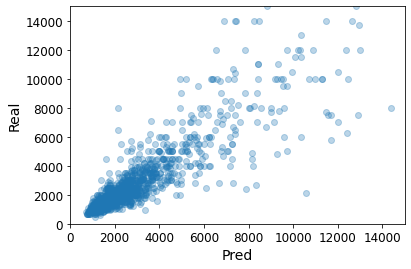

In [ ]:
ax = plt.scatter(final_predictions, y_test, alpha=0.3)
plt.xlim(0, 15000)
plt.ylim(0, 15000)
plt.xlabel('Pred') 
plt.ylabel('Real')